<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/aufgabe6/DeepReinforcementlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General idea:
1. Use a neural network that takes as input a state (represented as numbers)
and outputs a probability for every action.
2. Generate episodes by inputing the current state into the network and
sampling actions from the network’s output. Remember the
<state, action> pairs for every episode.
3. From these episodes, identify the ones with the highest reward.
4. Use the <state, action> pairs from those high reward episodes as
training examples for improving the neural network.
5. Go back to step 2

Task 2
1. Define a neural network with two fully connected-layers. The hidden layer uses a
Relu activation. The output layer uses a softmax. Try different hidden layer sizes
(between 100 and 500). The network takes as input a vector of the current states
and gives out a probability for each action.
2. Generate 100 episodes by sampling actions using the network output. Limit the
number of steps per episode to 500. Sum up the reward of all steps of one episode.
3. Print out the mean reward per episode of the 100 episodes.
4. Identify the 20 best of those episodes in terms of reward and use the
<state, action> pairs of these episodes as training examples for the network.
5. Update the weights of the network by performing backpropagation on these <state,
action> pairs.
6. Repeat steps 2 to 5 until a mean reward of 100 is reached.
7. Record a video of the lunar lander by running the trained network on one additional
episode.

Hints
* Use !pip3 install box2d-py to make the environment work in Colab.
* You cannot show the video of your lander in Colab (env.render() fails).  
* Workaround: Download the model on your local machine and record the video there,
using recording_demo.py as template (see Mattermost).
* The loss is not a useful indicator for the learning progress in RL. Instead check how
the mean reward develops over time.
* The mean reward will jump back and forth quite a bit, but overall should increase.
* After roughly 70 training iterations the mean reward should be positive, and after
roughly 100 steps be over 100.
* Note that these numbers depend on your parameter setting and it may also take
longer or shorter.
* Reinforcement learning is much more difficult than supervised learning, you have to
play around quite a bit to get things into the right direction.

# Imports

In [5]:
!pip3 install box2d-py gym > /dev/null

In [6]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
import torch.optim as optim
%matplotlib inline


In [7]:
env = gym.make('LunarLander-v2')
rewards = []

##get Action space
print(env.observation_space.shape)
print(env.action_space)
print()
print(env.observation_space.sample())
print(env.action_space.sample())


(8,)
Discrete(4)

[-0.77376556  1.6299638  -1.0327146  -1.9283904   0.5361454   1.3629391
 -0.17331174 -0.706725  ]
3


# Define Network

In [8]:

class Network(nn.Module):

    def __init__(self, hidden_size,):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size)
        self.fc2 = nn.Linear(hidden_size, env.action_space.n)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

In [9]:
net = Network(250)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)


# Sample Episodes

In [10]:
# get episodes
def sample(episodes_n=100, max_steps=5000):
  episodes_data = []
  
  softmax = nn.Softmax(dim=1)
  for i_episode in range(episodes_n):
      steps = [] # steps[0] is the action, steps[1] is the state
      total_reward = 0
      state = env.reset()
      for i_step in range(max_steps):

          state_vector = torch.FloatTensor([state])
          probability= softmax(net(state_vector))

          selected_action = np.random.choice(len(probability.data.numpy()[0]), p=probability.data.numpy()[0])
          new_state, reward, done, info = env.step(selected_action)

          rewards.append(reward)
          #important: use old state
          
          steps.append([selected_action, state])
          state = new_state
          total_reward += reward
          

          if done:
              episodes_data.append({ "total_reward": total_reward  ,"steps": steps})
              break
      #print(f"Mean reward of episode {i_episode}: {np.array(rewards).mean()}")
  return episodes_data


In [11]:
def calculate_total_mean_reward(all_episodes):
   all_rewards = [d['total_reward'] for d in all_episodes]
   return np.array(all_rewards).mean()

In [12]:
def get_top_20(all_episodes):
  return heapq.nlargest(20, all_episodes, key=lambda s: s['total_reward'])

In [13]:
def filter_batch(all_episodes,percentile=80):

    rewards_batch = [d['total_reward'] for d in all_episodes]
    reward_threshold = np.percentile(rewards_batch, percentile)
   
    top_20_p_episodes = []
    for episode in all_episodes:
      if episode['total_reward'] > reward_threshold:
        top_20_p_episodes.append(episode)
    return top_20_p_episodes

In [14]:
def get_training_data_batch(data):
  observations = []
  targets = []
  for entry in data:
    for step in entry['steps']:
      #state
      observations.append(step[1])
      #action
      targets.append(step[0])

  return [observations, targets]

In [15]:
def train_batch():
  
  # get the inputs; data is a list of [inputs, labels]
  training_data = sample(episodes_n=120)
  best_20 = get_top_20(training_data)
  observations, targets = get_training_data_batch(best_20)

  # calculate mean for the current episodes:

  #convert to torch?
  optimizer.zero_grad()
  observations=torch.FloatTensor(observations)
  targets =torch.LongTensor(targets)
  print(targets)

  # forward + backward + optimize
  action_pred = net(observations)

  loss = criterion(action_pred, targets)
  loss.backward()
  optimizer.step()
  reward_complete = calculate_total_mean_reward(training_data)
  return reward_complete, loss

  



In [19]:
i = 0
rewards = []
losses = []
while True:
  i+=1
  reward, loss = train_batch()
  print(f"{i}: Mean Reward for Sampling 100 episodes {reward}, Loss: {loss}")
  rewards.append(reward)
  losses.append(loss)

  if 150 < reward:
    break


tensor([3, 2, 1,  ..., 1, 3, 0])
1: Mean Reward for Sampling 100 episodes -134.36186507142784, Loss: 1.3303700685501099
tensor([0, 0, 0,  ..., 3, 1, 0])
2: Mean Reward for Sampling 100 episodes -170.948173889581, Loss: 1.339107632637024
tensor([3, 3, 2,  ..., 1, 2, 2])
3: Mean Reward for Sampling 100 episodes -155.79894817322835, Loss: 1.3438349962234497
tensor([3, 3, 2,  ..., 0, 0, 0])
4: Mean Reward for Sampling 100 episodes -152.09954459593183, Loss: 1.3341596126556396
tensor([0, 0, 3,  ..., 1, 3, 1])
5: Mean Reward for Sampling 100 episodes -135.86150995626912, Loss: 1.326799750328064
tensor([0, 1, 2,  ..., 2, 1, 1])
6: Mean Reward for Sampling 100 episodes -109.71902938339747, Loss: 1.2987562417984009
tensor([3, 1, 0,  ..., 0, 2, 2])
7: Mean Reward for Sampling 100 episodes -141.2439338084876, Loss: 1.2695581912994385
tensor([0, 2, 2,  ..., 2, 2, 2])
8: Mean Reward for Sampling 100 episodes -127.611744142535, Loss: 1.240256667137146
tensor([0, 1, 0,  ..., 2, 1, 1])
9: Mean Reward 

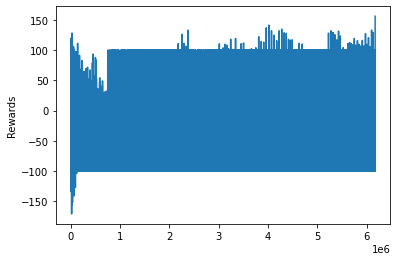

In [27]:
plt.plot(rewards)
plt.ylabel('Rewards')
plt.show()

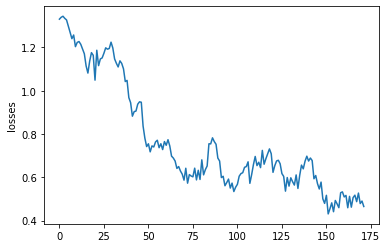

In [26]:
plt.plot(losses)
plt.ylabel("losses")
plt.show()

# Deprecated code

In [22]:
# depricated code
def get_training_data(episode_data):
  train_data = []
  for entry in episodes_data:
    for step in entry['steps']:
      one_hot = np.zeros(env.action_space.n)
      one_hot[step[0]] = 1
      train_data.append([one_hot, step[1]])
  return train_data

def train(training_data):
  for data in training_data:
    optimizer.zero_grad()
    # get the inputs; data is a list of [inputs, labels]
    action, observation = data
    #convert to torch?
    observation=torch.from_numpy(np.expand_dims(observation, axis=0))
    action =torch.from_numpy(np.array([np.argmax(action, axis=0)]))


    # forward + backward + optimize
    output_action = net(observation)
    loss = criterion(output_action, action)
    loss.backward()
    optimizer.step()

while False:
  episodes_data = sample(episodes_n=30)
  print(f"Mean Reward for Sampling 20 episodes {calculate_total_mean_reward(episodes_data)}")
  best_20 = get_top_20(episodes_data)
  train(get_training_data(best_20))

# Download Video

Code found [here](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=78BfQoQKOq7z)

In [23]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [24]:
## used for downloading videos
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env




In [2]:
env = wrap_env(gym.make("LunarLander-v2"))
softmax = nn.Softmax(dim=1)
reward2= 0
while True:
  observation = env.reset()
  while True:
    
    env.render()

    #your agent goes here
    state_vector = torch.FloatTensor([observation])
    probability= softmax(net(state_vector))

    new_state, reward, done, info = env.step(np.argmax(probability.data.numpy()[0], axis=0))
    if reward > 90:
      reward2 = reward
    if done:
      break
  if reward2 > 90:
    break
              
env.close()
show_video()

NameError: ignored